# 한글 Word2Vec 만들기

In [9]:
!pip install konlpy > /dev/null

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

In [11]:
df = pd.read_csv("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", sep='\t')
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 데이터 전처리

In [14]:
# 중복 여부 확인
df.shape, df.document.nunique()

((194544, 3), 194543)

In [13]:
# 중복 데이터 배제
df.drop_duplicates(subset=['document'], inplace=True)
df.shape

(194544, 3)

In [16]:
# Null data 있는지 확인
df.isnull().sum()

id          0
document    1
label       0
dtype: int64

In [17]:
# Null data 제거
df.dropna(how='any', inplace=True)
df.shape

(194543, 3)

In [20]:
# 한글과 공백 이외는 제거
df['document'] = df.document.str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣]', '')
df.head(5)

,id,document,label
0,8112052,어릴때보고지금다시봐도재밌어요ㅋㅋ,1
1,8132799,디자인을배우는학생으로외국디자이너와그들이일군전통을통해발전해가는문화산업이부러웠는데사실우...,1
2,4655635,폴리스스토리시리즈는부터뉴까지버릴께하나도없음최고,1
3,9251303,와연기가진짜개쩔구나지루할거라고생각했는데몰입해서봤다그래이런게진짜영화지,1
4,10067386,안개자욱한밤하늘에떠있는초승달같은영화,1


In [21]:
df['document'].replace('', np.nan, inplace=True)
df.document.isnull().sum()

1025

In [22]:
df.dropna(how='any', inplace=True)
df.shape

(193518, 3)

- 불용어 샂전 활용하여 불용어 처리

In [23]:
from google.colab import files
uploaded = files.upload()
filename = list(uploaded.keys())[0]

Saving 한글불용어100.txt to 한글불용어100.txt


In [24]:
sdf =pd.read_csv(filename, sep='\s+', header=None)
sdf.head()

,0,1,2
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898


In [25]:
# 품사를 무시하고 중복 배제
stopwords = set(sdf[0])
len(stopwords)

94

In [35]:
print(stopwords)

{'집', '모르', '년', '싶', '번', '시간', '다시', '없', '않', '받', '크', '지금', '속', '원', '중', '좀', '위하', '시키', '적', '수', '개', '한', '말', '이런', '살', '보', '생각하', '사회', '씨', '그', '이', '좋', '보이', '하', '통하', '문제', '때문', '주', '그녀', '더', '만들', '알', '나오', '사람', '오', '같', '때', '앞', '여자', '그런', '데', '못하', '대하', '따르', '어떻', '있', '많', '가', '점', '명', '월', '전', '나', '또', '사실', '아니', '우리', '소리', '등', '하나', '생각', '그러', '지', '놓', '그것', '들', '일', '두', '것', '내', '어떤', '그리고', '자신', '경우', '가지', '잘', '다른', '이렇', '되', '정도', '그렇', '그러나', '말하', '안'}


In [36]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

- 한글 형태소 분석

In [27]:
okt = Okt()

In [37]:
from tqdm.notebook import tqdm
tokenized_data = []
for sentence in tqdm(df.document):
    morphs = okt.morphs(sentence.strip(), stem=True)
    temp_list = [word for word in morphs if word not in stopwords]
    tokenized_data.append(temp_list)

  0%|          | 0/193518 [00:00<?, ?it/s]

리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.978461951859776


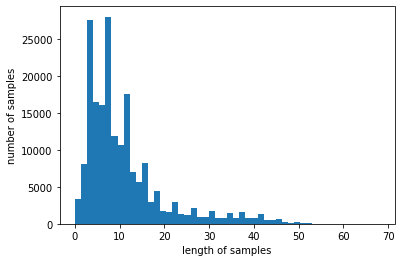

In [38]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

## Word2Vec 훈련시키기
- size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
- window = 컨텍스트 윈도우 크기
- min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
- workers = 학습을 위한 프로세스 수
- sg = 0은 CBOW, 1은 Skip-gram.

In [40]:
from gensim.models import Word2Vec
%time model = Word2Vec( \
    sentences=tokenized_data, size=100, \
    window=5, min_count=5, workers=4, sg=0 \
)

CPU times: user 41.4 s, sys: 283 ms, total: 41.6 s
Wall time: 24.7 s


In [41]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(17932, 100)

In [42]:
model.wv.most_similar("최민식")

[('한석규', 0.8785180449485779),
 ('안성기', 0.8660780191421509),
 ('이정재', 0.8648302555084229),
 ('최민수', 0.8622485399246216),
 ('김수현', 0.8539552688598633),
 ('채민서', 0.8517400026321411),
 ('윤제문', 0.8513284921646118),
 ('단역', 0.851168155670166),
 ('설경구', 0.8491491079330444),
 ('김창완', 0.8475708365440369)]

In [43]:
model.wv.most_similar("히어로")

[('느와르', 0.8719092607498169),
 ('무협', 0.8512718081474304),
 ('호러', 0.850765585899353),
 ('블록버스터', 0.8482139110565186),
 ('홍콩', 0.8421063423156738),
 ('슬래셔', 0.8416706919670105),
 ('무비', 0.8340630531311035),
 ('정통', 0.8217722177505493),
 ('패러디', 0.8097231388092041),
 ('물의', 0.8050495386123657)]